# Capital Adequacy and the Basel Framework — Module 1

This notebook introduces CET1 ratio, Leverage Ratio, and RWA under normal and stressed conditions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print('Environment ready')

Environment ready


## Learning Objectives
- Evolution from Basel I to Basel IV
- The three pillars of regulation
- Quantify capital (CET1, Leverage) and RWA under normal and stressed conditions

## Setup

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## Key Formulae
- RWA = sum(exposure_i * risk_weight_i)
- CET1 Ratio = CET1 / RWA
- Leverage Ratio = Tier1 / ExposureMeasure (simplified Tier1≈CET1; exposure = on-balance-sheet assets)

## Parameters — Simplified Balance Sheet (in £m)

In [3]:
assets = {
    'Cash & Central Bank Reserves': 200.0,
    'Sovereign Bonds (AAA/Aaa)': 300.0,
    'Prime Mortgages': 500.0,
    'Retail Unsecured': 250.0,
    'Corporate Loans (BBB)': 400.0,
}

liabilities = {
    'Customer Deposits': 1350.0,
    'Senior Unsecured Debt': 200.0,
}

CET1 = 100.0

risk_weights = {
    'Cash & Central Bank Reserves': 0.00,
    'Sovereign Bonds (AAA/Aaa)': 0.00,
    'Prime Mortgages': 0.35,
    'Retail Unsecured': 0.75,
    'Corporate Loans (BBB)': 1.00,
}

stress_loss_rates = {
    'Prime Mortgages': 0.01,
    'Retail Unsecured': 0.05,
    'Corporate Loans (BBB)': 0.07,
}

risk_weight_multiplier_stress = 1.2

pd.DataFrame([assets, liabilities], index=['Assets (£m)', 'Liabilities (£m)']).T

,Assets (£m),Liabilities (£m)
Cash & Central Bank Reserves,200.00,NaN
Sovereign Bonds (AAA/Aaa),300.00,NaN
Prime Mortgages,500.00,NaN
Retail Unsecured,250.00,NaN
Corporate Loans (BBB),400.00,NaN
Customer Deposits,NaN,"1,350.00"
Senior Unsecured Debt,NaN,200.00


## Helper Functions

In [4]:
def total_assets(assets):
    return float(sum(assets.values()))

def total_liabilities(liabs):
    return float(sum(liabs.values()))

def compute_rwa(assets, rw):
    return float(sum(assets[k]*rw.get(k,0.0) for k in assets))

def leverage_exposure_measure(assets):
    return total_assets(assets)

def cet1_ratio(cet1, rwa):
    return cet1/rwa if rwa>0 else float('inf')

def leverage_ratio(tier1, exposure):
    return tier1/exposure if exposure>0 else float('inf')

def apply_stress(assets, cet1, stress_losses, rw, rw_multiplier=1.0):
    stressed_assets = assets.copy()
    stressed_cet1 = float(cet1)
    for k, lr in stress_losses.items():
        exp_before = stressed_assets.get(k, 0.0)
        loss = exp_before * float(lr)
        stressed_assets[k] = exp_before - loss
        stressed_cet1 -= loss
    stressed_rw = {k: v*rw_multiplier for k, v in rw.items()}
    return stressed_assets, stressed_cet1, stressed_rw


## Compute Ratios — Normal vs Stressed

In [5]:
# Normal
A_norm = total_assets(assets)
L_norm = total_liabilities(liabilities)
E_norm_model = A_norm - L_norm
balance_check = CET1 - E_norm_model

RWA_norm = compute_rwa(assets, risk_weights)
LR_exposure_norm = leverage_exposure_measure(assets)

cet1_ratio_norm = cet1_ratio(CET1, RWA_norm)
leverage_ratio_norm = leverage_ratio(CET1, LR_exposure_norm)

summary_norm = pd.Series({
    'Total Assets (£m)': A_norm,
    'Total Liabilities (£m)': L_norm,
    'CET1 Declared (£m)': CET1,
    'CET1 minus (A-L) (sanity)': balance_check,
    'RWA (£m)': RWA_norm,
    'CET1 Ratio': cet1_ratio_norm,
    'Leverage Exposure (£m)': LR_exposure_norm,
    'Leverage Ratio': leverage_ratio_norm,
}, name='Normal')

# Stressed
assets_stress, CET1_stress, rw_stress = apply_stress(
    assets, CET1, stress_loss_rates, risk_weights, risk_weight_multiplier_stress
)

A_stress = total_assets(assets_stress)
L_stress = total_liabilities(liabilities)
RWA_stress = compute_rwa(assets_stress, rw_stress)
LR_exposure_stress = leverage_exposure_measure(assets_stress)

cet1_ratio_stress = cet1_ratio(CET1_stress, RWA_stress)
leverage_ratio_stress = leverage_ratio(CET1_stress, LR_exposure_stress)

summary_stress = pd.Series({
    'Total Assets (£m)': A_stress,
    'Total Liabilities (£m)': L_stress,
    'CET1 Declared (£m)': CET1_stress,
    'RWA (£m)': RWA_stress,
    'CET1 Ratio': cet1_ratio_stress,
    'Leverage Exposure (£m)': LR_exposure_stress,
    'Leverage Ratio': leverage_ratio_stress,
}, name='Stressed')

summary_df = pd.concat([summary_norm, summary_stress], axis=1)
summary_df

,Normal,Stressed
Total Assets (£m),"1,650.00","1,604.50"
Total Liabilities (£m),"1,550.00","1,550.00"
CET1 Declared (£m),100.00,54.50
CET1 minus (A-L) (sanity),0.00,NaN
RWA (£m),762.50,868.05
CET1 Ratio,0.13,0.06
Leverage Exposure (£m),"1,650.00","1,604.50"
Leverage Ratio,0.06,0.03


### Detailed Asset Breakdown (Normal vs Stressed)

In [6]:
assets_df = pd.DataFrame({
    'Asset Class': list(assets.keys()),
    'Exposure Normal (£m)': list(assets.values()),
    'Risk Weight Normal': [risk_weights[k] for k in assets.keys()],
})
assets_df['RWA Normal (£m)'] = assets_df['Exposure Normal (£m)'] * assets_df['Risk Weight Normal']

assets_stress_df = pd.DataFrame({
    'Asset Class': list(assets_stress.keys()),
    'Exposure Stressed (£m)': list(assets_stress.values()),
    'Risk Weight Stressed': [rw_stress[k] for k in assets_stress.keys()],
})
assets_stress_df['RWA Stressed (£m)'] = assets_stress_df['Exposure Stressed (£m)'] * assets_stress_df['Risk Weight Stressed']

detail_df = assets_df.merge(assets_stress_df, on='Asset Class', how='outer')
detail_df.fillna(0.0, inplace=True)
detail_df

,Asset Class,Exposure Normal (£m),Risk Weight Normal,RWA Normal (£m),Exposure Stressed (£m),Risk Weight Stressed,RWA Stressed (£m)
0,Cash & Central Bank Reserves,200.00,0.00,0.00,200.00,0.00,0.00
1,Corporate Loans (BBB),400.00,1.00,400.00,372.00,1.20,446.40
2,Prime Mortgages,500.00,0.35,175.00,495.00,0.42,207.90
3,Retail Unsecured,250.00,0.75,187.50,237.50,0.90,213.75
4,Sovereign Bonds (AAA/Aaa),300.00,0.00,0.00,300.00,0.00,0.00


### Visualise Ratios (Normal vs Stressed)

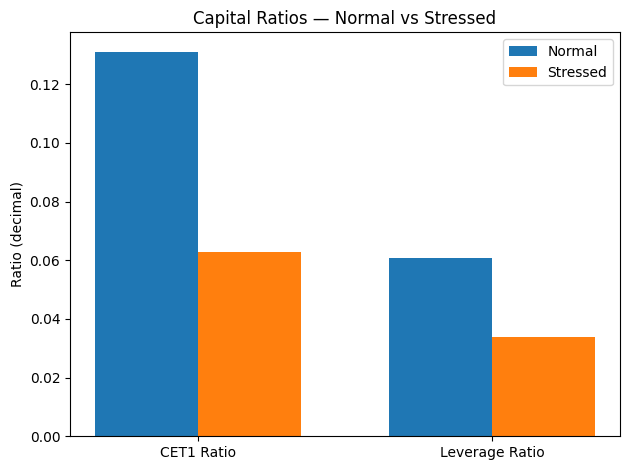

In [7]:
labels = ['CET1 Ratio', 'Leverage Ratio']
norm_vals = [cet1_ratio_norm, leverage_ratio_norm]
stress_vals = [cet1_ratio_stress, leverage_ratio_stress]

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, norm_vals, width, label='Normal')
plt.bar(x + width/2, stress_vals, width, label='Stressed')
plt.xticks(x, labels)
plt.ylabel('Ratio (decimal)')
plt.title('Capital Ratios — Normal vs Stressed')
plt.legend()
plt.tight_layout()
plt.show()

## Evolution: Basel I to the 'Basel IV' Finalisation
- Basel I (1988): simple credit risk buckets; 8% total capital ratio.
- Basel II (2004): Three Pillars; IRB; operational risk; more risk sensitivity.
- Basel III (2010–2017): stronger CET1, buffers (CCB/CCyB), LCR/NSFR, Leverage Ratio.
- Basel III finalisation (often called Basel IV, 2017+): output floors, revised standardized/IRB credit risk, new op‑risk SMA, FRTB (market risk).

## The Three Pillars — Why Each Matters
- Pillar 1: Minimum capital requirements (credit, market, operational risk).
- Pillar 2: Supervisory review (ICAAP/SREP), bank‑specific risks, governance, stress testing, add‑ons.
- Pillar 3: Market discipline through disclosures, comparability, and transparency.

## How Capital Maintains Solvency & Confidence
- CET1 absorbs losses first; protects depositors and creditors.
- Strong capital supports funding access and reduces distress probability.
- Buffers (CCB/CCyB/systemic) can be released in downturns.
- Leverage Ratio backstops risk‑weight uncertainty.

## Exercises
1) Add a 150% RW bucket for sub‑IG corporates and recompute.
2) Increase stress loss rates and reduce CET1; re‑run.
3) Extend leverage exposure with simple CCFs for off‑balance‑sheet items.
4) When might the Leverage Ratio be the binding constraint?

## Appendix — Export Key Results

In [9]:
out = pd.DataFrame({
    'Metric': ['CET1 Ratio (Normal)', 'CET1 Ratio (Stressed)', 'Leverage Ratio (Normal)', 'Leverage Ratio (Stressed)'],
    'Value': [cet1_ratio_norm, cet1_ratio_stress, leverage_ratio_norm, leverage_ratio_stress]
})
out_path = 'basel_module1_key_results.csv'
out.to_csv(out_path, index=False)
out, out_path

(                      Metric  Value
 0        CET1 Ratio (Normal)   0.13
 1      CET1 Ratio (Stressed)   0.06
 2    Leverage Ratio (Normal)   0.06
 3  Leverage Ratio (Stressed)   0.03,
 'basel_module1_key_results.csv')

---
**Note:** Educational simplification. Not regulatory guidance.